# Introduction to the Quantum Inspire API

![<Quantum Inspire Logo>](./index.png)

## Step 0: Create account and run a job via the web interface (demo in browser)

![<Login>](./login.png)

## Step 1: SDK installation

![<Github>](./github.png)

Instead of the web interface, we can run advanced algorithms by interacting with the Quantum Inspire platform directly from python.  
We assume that you already have a working python environment setup. If not, a possible way to create one using [*conda*](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) is by running
```
conda create --name EQTC_workshop python=3.8
conda activate EQTC_workshop
```

We first need to install the SDK. It's code is available on [Github](https://github.com/QuTech-Delft/quantuminspire) and is simply installable via `pip`:
```
pip install quantuminspire
```
For our next example, we will also need the following packages:
```
pip install numpy scipy matplotlib networkx qiskit
```
If you already have some of those packages installed, please make sure you are on the latest version (especially for `qiskit`).

## Step 2: API authentication

### Single-use authentication

We need to authenticate with the API by using the same account we created via the web interface.  
We provide our credentials and pass them together with the URL to the API object. This is okay for a single use.

In [ ]:
from getpass import getpass
from coreapi.auth import BasicAuthentication
from quantuminspire.api import QuantumInspireAPI

print('Enter mail address:')
email = input()

print('Enter password:')
password = getpass()

QI_URL = r'https://api.quantum-inspire.com'
authentication = BasicAuthentication(email, password)
qi = QuantumInspireAPI(QI_URL, authentication, 'my-project-name')

### Alternative: token authentication

To avoid having to type our login information every time we start a new session, we can conveniently use the API token provided on the website account interface 
> ___My QI --> Account --> Your API Token___

![<Token>](./token.png)

We only need to copy the token into the notebook and call `save_account()`, `enable_account()` once.  
After that, only the call to `get_authentication()` is needed to retrieve the saved token and start a new session.  
This allows to __keep your token secret__ and __not having to keep it in plain text__ in your code! (the token shown here is already invalidated)

In [2]:
from quantuminspire.credentials import get_token_authentication, save_account, enable_account, get_authentication
from quantuminspire.api import QuantumInspireAPI

# these two calls are only needed once, later we only need to call get_authetication to start a new session
# token = '0b76ad1f278fa02704ed9c9ea0bdb5a91da7967c'
# save_account(token)
# enable_account(token)

QI_URL = r'https://api.quantum-inspire.com/'
authentication = get_authentication()
qi = QuantumInspireAPI(QI_URL, authentication)

## Backends
In this example, we will first use the [QX Emulator](https://www.quantum-inspire.com/kbase/emulator-backends/) as backend. Then we will run our code on [Starmon-5](https://www.quantum-inspire.com/kbase//starmon-5-operational-specifics/).  
It is possible to ask the API for all available backends and their detailed information, like so:

In [3]:
# entry for Starmon-5
qi.get_backend_types()[1]

OrderedDict([('url', 'https://api.quantum-inspire.com/backendtypes/11/'),
             ('name', 'Starmon-5'),
             ('is_hardware_backend', True),
             ('required_permission', 'can_execute'),
             ('number_of_qubits', 5),
             ('description', ''),
             ('topology',
              OrderedDict([('edges', [[2], [2], [0, 1, 3, 4], [2], [2]])])),
             ('is_allowed', True),
             ('status', 'IDLE'),
             ('status_message', ''),
             ('chip_image_id', '4386293'),
             ('calibration',
              'https://api.quantum-inspire.com/backendtypes/11/calibration/'),
             ('allowed_operations',
              OrderedDict([('display', []),
                           ('measure',
                            ['measure',
                             'measure_x',
                             'measure_y',
                             'measure_z']),
                           ('measure_all', ['measure_all']),
              

This gives you important information, like the types of gates that are allowed on this backend and its topology (connectivity).  
To choose a backend, we simply provide the result of the following call to the API object's `execute_qasm()` method (see below).

In [4]:
from pprint import pprint
backend_type = qi.get_backend_type('QX single-node simulator')
pprint(backend_type)

{'allowed_operations': OrderedDict(),
 'calibration': 'https://api.quantum-inspire.com/backendtypes/1/calibration/',
 'chip_image_id': None,
 'default_number_of_shots': 1024,
 'description': 'Single-node [QX Simulator](/kbase/qxsimulator) running on a '
                '4GB Hetzner VPS, max 25 qubits.',
 'is_allowed': True,
 'is_hardware_backend': False,
 'max_number_of_shots': 4096,
 'max_number_of_simultaneous_jobs': 0,
 'name': 'QX single-node simulator',
 'number_of_qubits': 26,
 'operations_count': OrderedDict([('max_operations_for_qubit', 0),
                                  ('total_operations', 0)]),
 'required_permission': 'can_simulate_single_node_qutech',
 'status': 'IDLE',
 'status_message': '',
 'topology': OrderedDict([('edges', [])]),
 'url': 'https://api.quantum-inspire.com/backendtypes/1/'}


# Deutsch–Jozsa algorithm description

In the *Deutsch–Jozsa algorithm* we use an **oracle to determine if a binary function** 
$$f(x) : \{0,1\}^n \rightarrow \{0,1\}$$ 
is constant or balanced.

A function is **constant** if $f(x)=0$ or $f(x)=1$ for all values of $x$.  
A function is **balanced** if $f(x)=0$ for half of the possible input values $x$ and $f(x)=1$ for the other half.  
The task is to distinguish the balanced case (half of all inputs yield output 1) from the constant case (all or none of the inputs yield output 1).  
You can read more about this algorithm on [Wikipedia](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm) or on the [Quantum Algorithm Zoo](https://quantumalgorithmzoo.org/).

## What is it used for?
The Deutsch-Josza algorithm is a simple example of a quantum algorithm that can be used to speed up a search. As will be explained below, it can determine whether or not a function has a certain property (being balanced). The algorithm achieves this by requiring that the function (more precisely, a derivation of the function) need only be called once with a quantum algorithm instead of twice with a classical algorithm. When the function is very 'expensive', e.g., in terms of computational resources, it can be very beneficial if you have to compute this function only once instead of twice.

Although the speed-up of this specific case of a 2-to-1 bit function is only a factor of 2, in general **this algorithm can achieve exponential speedup** (for the worst case of the classical counterpart). Historically, this is **the first well-defined quantum algorithm achieving a speedup over classical computation.**

## How does it work?
In this example we consider a binary function $f(x) : \{0,1\} \rightarrow \{0,1\}$. There are four possibilities for the function $f(x)$, which we call the **Oracle function**. These
are:
1. $$f_1(x)=0$$
2. $$f_2(x)=1$$
3. $$f_3(x)=x$$
4. $$f_4(x)=1-x$$

**The algorithm to determine whether our function $f(x)$ is constant or balanced requires only a single query of $f(x)$**.

In this example, we will implement a very simple Oracle for the four different functions, but a much more complex Oracle could also be used. 


## Implementation in cQASM
The following code shows the implementation of the algorithm, which uses two qubits.

We use an oracle to determine if a binary function $f(x)$ is constant or balanced.  
Here, the constant  cases are $f(x)=fc1=0$ and $f(x)=fc2=1$, and balanced cases $f(x)=fb3=x$ and $f(x)=fb4=NOT(x)$.  
By changing the Oracle, the 4 different functions can be tested.

In [5]:
def get_dj_oracle_circuit(oracle: str = 'NOT(x)'):
    qasm_str = """
version 1.0
qubits 5

# Initialize qubits in |+> and |-> state
.initialize
{prep_z q[0]|prep_z q[2]}
X q[2]
{H q[0]|H q[2]}
"""
    
    if oracle == '0':
        qasm_str += """
.oracle_fc1
# do nothing or call idle gate 
{I q[0]|I q[2]}
"""
    elif oracle == '1':
        qasm_str += """  
.oracle_fc2
X q[2]
"""
    elif oracle == 'x':
        qasm_str += """          
.oracle_fb3
CNOT q[0],q[2]
"""
    elif oracle == 'NOT(x)':
        qasm_str += """  
.oracle_fb4
CNOT q[0],q[2]
X q[2]
"""
    else:
        raise ValueError("Oracle function must be one of ['0', '1', 'x', 'NOT(x)'].")
        
    qasm_str += """
.measurement
H q[0]
measure q[0]
"""
    return qasm_str

## Running a simulation
Let us generate a circuit for oracle $fc1$ and simulate it. What do you expect from the result?  

You can find more information about [executing an algorithm](https://www.quantum-inspire.com/kbase//executing-your-algorithm/) and [examining results](https://www.quantum-inspire.com/kbase/displaying-and-downloading-your-results/) in the knowledge base.

In [6]:
qc = get_dj_oracle_circuit(oracle='0')
print(qc)


version 1.0
qubits 5

# Initialize qubits in |+> and |-> state
.initialize
{prep_z q[0]|prep_z q[2]}
X q[2]
{H q[0]|H q[2]}

.oracle_fc1
# do nothing or call idle gate 
{I q[0]|I q[2]}

.measurement
H q[0]
measure q[0]



We now call the `execute_qasm` method with our generate circuit-string and the desired simulation backend, and examine the histogram of results.

In [7]:
backend_type = qi.get_backend_type('QX single-node simulator')
result = qi.execute_qasm(qc, backend_type=backend_type, user_data="Deutsch-Josza test")
counts = result['histogram']
pprint(result)

Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


{'calibration': None,
 'created_at': '2021-11-26T14:19:25.295112Z',
 'execution_time_in_seconds': 33.92506647109985,
 'histogram': OrderedDict([('0', 1.0)]),
 'histogram_url': 'https://api.quantum-inspire.com/results/7069997/histogram/2e4342a98c37ac56ed89748ec282b6f4c00c97c591eba0b8d8eb426fb400af05/',
 'id': 7069997,
 'job': 'https://api.quantum-inspire.com/jobs/7078018/',
 'measurement_mask': 0,
 'measurement_register_url': 'https://api.quantum-inspire.com/results/7069997/measurement-register/2e4342a98c37ac56ed89748ec282b6f4c00c97c591eba0b8d8eb426fb400af05/',
 'number_of_qubits': 5,
 'quantum_states_url': 'https://api.quantum-inspire.com/results/7069997/quantum-states/2e4342a98c37ac56ed89748ec282b6f4c00c97c591eba0b8d8eb426fb400af05/',
 'raw_data_url': 'https://api.quantum-inspire.com/results/7069997/raw-data/2e4342a98c37ac56ed89748ec282b6f4c00c97c591eba0b8d8eb426fb400af05/',
 'raw_text': '',
 'url': 'https://api.quantum-inspire.com/results/7069997/'}


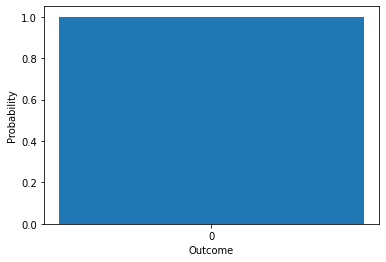

In [8]:
import matplotlib.pyplot as plt
plt.xlabel("Outcome")
plt.ylabel("Probability")
plt.bar(counts.keys(), counts.values(), align='center')
plt.show()

Not surprisingly, our perfect (noise-free) simulation of the quantum circuit gives a perfect result.  
If we now run the same code again, but this time implement the 2nd Oracle, we would see that we get exactly the same result as for the first oracle.

Likewise, we can run the algorithm for Oracle 3 or Oracle 4. In these cases, we will get a different result:

In [9]:
qc = get_dj_oracle_circuit(oracle='NOT(x)')
backend_type = qi.get_backend_type('QX single-node simulator')
result = qi.execute_qasm(qc, backend_type=backend_type, user_data="Deutsch-Josza test")
counts = result['histogram']
pprint(result)

Your experiment can not be optimized and may take longer to execute, see https://www.quantum-inspire.com/kbase/optimization-of-simulations/ for details.


{'calibration': None,
 'created_at': '2021-11-26T14:20:04.791695Z',
 'execution_time_in_seconds': 36.0304000377655,
 'histogram': OrderedDict([('1', 1.0)]),
 'histogram_url': 'https://api.quantum-inspire.com/results/7069998/histogram/6a3c0574185e12baf7742ccbd55c009be02902746e043c73dc5c3842071666c1/',
 'id': 7069998,
 'job': 'https://api.quantum-inspire.com/jobs/7078019/',
 'measurement_mask': 0,
 'measurement_register_url': 'https://api.quantum-inspire.com/results/7069998/measurement-register/6a3c0574185e12baf7742ccbd55c009be02902746e043c73dc5c3842071666c1/',
 'number_of_qubits': 5,
 'quantum_states_url': 'https://api.quantum-inspire.com/results/7069998/quantum-states/6a3c0574185e12baf7742ccbd55c009be02902746e043c73dc5c3842071666c1/',
 'raw_data_url': 'https://api.quantum-inspire.com/results/7069998/raw-data/6a3c0574185e12baf7742ccbd55c009be02902746e043c73dc5c3842071666c1/',
 'raw_text': '',
 'url': 'https://api.quantum-inspire.com/results/7069998/'}


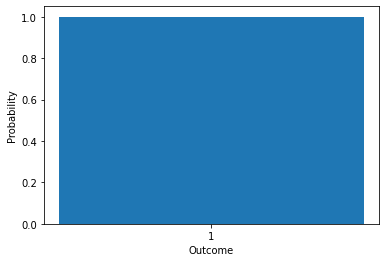

In [10]:
plt.xlabel("Outcome")
plt.ylabel("Probability")
plt.bar(counts.keys(), counts.values(), align='center')
plt.show()

## Now let's try it on Starmon-5

In [11]:
backend_type = qi.get_backend_type_by_name('Starmon-5')
result = qi.execute_qasm(qc, backend_type=backend_type, number_of_shots=2**12, user_data="Deutsch-Josza test")
counts = result['histogram']
pprint(result)

{'calibration': 'https://api.quantum-inspire.com/calibration/109027/',
 'created_at': '2021-11-26T14:20:34.225194Z',
 'execution_time_in_seconds': 0.622592,
 'histogram': OrderedDict([('0', 0.133056640625), ('1', 0.866943359375)]),
 'histogram_url': 'https://api.quantum-inspire.com/results/7069999/histogram/8f68530d812b09152eaebbe41d84e43ba2cc91b25dbeccae462c188e4ee9ec51/',
 'id': 7069999,
 'job': 'https://api.quantum-inspire.com/jobs/7078020/',
 'measurement_mask': 1,
 'measurement_register_url': 'https://api.quantum-inspire.com/results/7069999/measurement-register/8f68530d812b09152eaebbe41d84e43ba2cc91b25dbeccae462c188e4ee9ec51/',
 'number_of_qubits': 5,
 'quantum_states_url': 'https://api.quantum-inspire.com/results/7069999/quantum-states/8f68530d812b09152eaebbe41d84e43ba2cc91b25dbeccae462c188e4ee9ec51/',
 'raw_data_url': 'https://api.quantum-inspire.com/results/7069999/raw-data/8f68530d812b09152eaebbe41d84e43ba2cc91b25dbeccae462c188e4ee9ec51/',
 'raw_text': '',
 'url': 'https://api

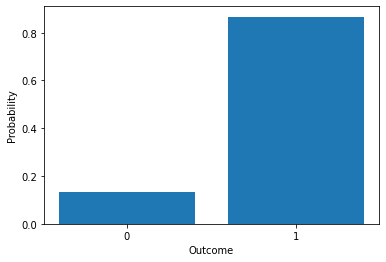

In [12]:
plt.xlabel("Outcome")
plt.ylabel("Probability")
plt.bar(counts.keys(), counts.values(), align='center')
plt.show()

Now things look very different! Due to the noise on a real quantum processor, we do not measure the correct result 100% of the time anymore.  
However, we can still retrieve the correct answer with high probability, which is what usually matters in practice.

**You have now learned how to connect to the Quantum Inspire API from a python session and execute cQASM-algorithms on different simulation- and hardware-backends.**  
**Next, we will proceed with an example of QAOA, a more advanced algorithm that we can run on Quantum Inspire.**